#  Logistic Modeling of PACT Initial Custody Level 

This notebook contains the initial custody level logistic models for the papers.

## Notebook Setup

In [1]:
import sys
sys.path.append("../src")
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from heatmap import heatmap
import statsmodels.formula.api as smf
import bioinfokit

In [3]:
from math391.models.logit_models import LogitModelRunner
from math391.preprocessing import preprocess_for_logit
from math391.plotting import roc_plot

In [4]:
plt.style.use('ggplot')

In [5]:
def corrplot(data, size_scale=500, marker='s'):
    corr = pd.melt(data.reset_index(), id_vars='index').replace(np.nan, 0)
    corr.columns = ['x', 'y', 'value']
    heatmap(
        corr['x'], corr['y'],
        color=corr['value'], color_range=[-1, 1],
        palette=sns.diverging_palette(240, 10, n=256),
        size=corr['value'].abs(), size_range=[0,1],
        marker=marker,
        x_order=data.columns,
        y_order=data.columns[::-1],
        size_scale=size_scale
    )

---

## Loading the data

In [6]:
df_ic_all = preprocess_for_logit(
    pd.read_csv(
        "../data/initial_custody_gsprs.csv",
        low_memory=False
    )
)

df_ic_all = df_ic_all[
    [
        "gender_female",
        "age_gt_45",
        "age_lt_25",
        "race_B",
        "race_A",
        "race_H",
        "race_I",
        "race_O",
        "off_1_prs_max",
        "off_1_gs_max",
        "custody_level",
        "prior_commits",
        "ic_institut_adj",
        "escape_hist_1",
        "escape_hist_2",
        "escape_hist_3",
        "escape_hist_4",
        "escape_hist_5",
        "mrt_stat_DIV",
        "mrt_stat_SEP",
        "mrt_stat_MAR",
        "mrt_stat_WID",
        "employed"
    ]
]


df_ic_all = df_ic_all.dropna()

In [7]:
df_ic_all['gender_female'].describe()

count    29622.000000
mean         0.924448
std          0.264284
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: gender_female, dtype: float64

In [20]:
df_ic_all['off_1_prs_max'].describe()

count    29622.000000
mean         2.455844
std          1.066985
min          0.500000
25%          1.000000
50%          3.000000
75%          3.000000
max          4.000000
Name: off_1_prs_max, dtype: float64

In [21]:
pd.crosstab(df_ic_all.ic_institut_adj,df_ic_all.custody_level, margins=True)

custody_level,0,1,All
ic_institut_adj,,,
1.0,1105,112,1217
2.0,14369,2855,17224
3.0,2158,878,3036
4.0,987,2229,3216
5.0,525,4404,4929
All,19144,10478,29622


---

## Feature selection

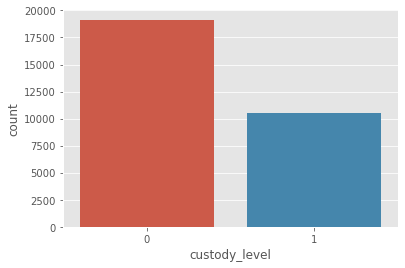

In [22]:
#balanced class distribution

import seaborn as sns
ax = sns.countplot(x='custody_level', data=df_ic_all)
plt.show()

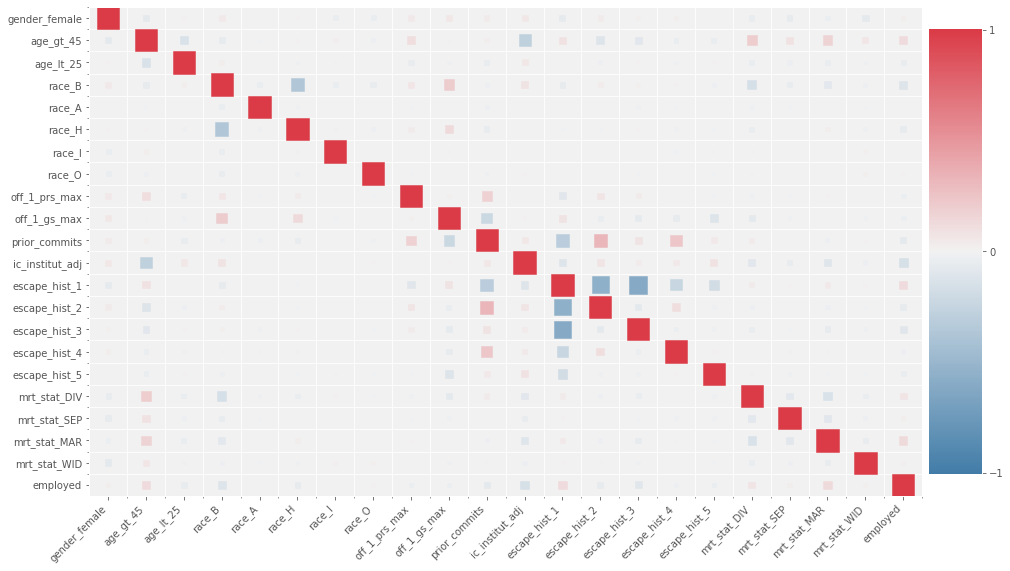

In [23]:
model_ic_all = LogitModelRunner(
    df=df_ic_all,
    target_var="custody_level"
)

plt.figure(figsize=(16,9))
corrplot(model_ic_all.X_train.corr())
plt.show()

In [37]:
# Scale the quantitative data

from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler()
scaler.fit(df_ic_all) 
df_ic_scaled = pd.DataFrame(scaler.transform(df_ic_all),columns = df_ic_all.columns)




In [40]:
df_ic_scaled['off_1_gs_max'].describe()

count    29622.000000
mean         0.737314
std          0.239322
min          0.000000
25%          0.500000
50%          0.785714
75%          0.928571
max          1.000000
Name: off_1_gs_max, dtype: float64

In [41]:
df_ic_all['off_1_gs_max'].describe()

count    29622.000000
mean        11.322396
std          3.350501
min          1.000000
25%          8.000000
50%         12.000000
75%         14.000000
max         15.000000
Name: off_1_gs_max, dtype: float64

In [47]:
model = smf.logit("custody_level ~ C(gender_female)+C(age_gt_45)+C(age_lt_25)+C(race_B)+C(race_H)+C(race_A)+C(race_I)+C(race_O)+prior_commits+C(escape_hist_1)+C(escape_hist_2)+C(escape_hist_3)+C(escape_hist_4)+C(escape_hist_5)+C(mrt_stat_DIV)+C(mrt_stat_SEP)+C(mrt_stat_MAR)+C(mrt_stat_WID)+C(employed)+off_1_gs_max+off_1_prs_max", data = df_ic_all).fit()

Optimization terminated successfully.
         Current function value: 0.490254
         Iterations 7


In [48]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          custody_level   No. Observations:                29622
Model:                          Logit   Df Residuals:                    29600
Method:                           MLE   Df Model:                           21
Date:                Sun, 26 Sep 2021   Pseudo R-squ.:                  0.2454
Time:                        00:11:21   Log-Likelihood:                -14522.
converged:                       True   LL-Null:                       -19246.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -1.7094      0.108    -15.849      0.000      -1.921      -1.498
C(gender_female)[T.1]     0.2826      0.061      4.619      0.000       0.163       0.402
C(age_gt_45)[T.1]        -1.1178      0.031    -36.216      0.000      -1.178      -1.057
C(age_lt_25)[T.1]         0.5505      0.115      4.775      0.000       0.325       0.776
C(race_B)[T.1]            0.3307      0.034      9.796      0.000       0.265       0.397
C(race_H)[T.1]           -0.0608      0.049     -1.236      0.216      -0.157       0.036
C(race_A)[T.1]            0.5741      0.306      1.878      0.060      -0.025       1.173
C(race_I)[T.1]            0.6756      0.396      1.706      0.088      -0.101       1.452
C(race_O)[T.1]            0.5485      0.259      2.115      0.034       0.040       1.057
C(escape_hist_1)[T.1]    -0.7170      0.066    -10.921      0.000      -0.846      -0.588
C(escape_hist_2)[T.1]    -0.2655      0.058     -4.598      0.000      -0.379      -0.152
C(escape_hist_3)[T.1]    -0.1366      0.058     -2.347      0.019      -0.251      -0.023
C(escape_hist_4)[T.1]     1.2107      0.075     16.148      0.000       1.064       1.358
C(escape_hist_5)[T.1]     2.1908      0.108     20.212      0.000       1.978       2.403
C(mrt_stat_DIV)[T.1]     -1.7629      0.072    -24.471      0.000      -1.904      -1.622
C(mrt_stat_SEP)[T.1]     -1.6029      0.090    -17.767      0.000      -1.780      -1.426
C(mrt_stat_MAR)[T.1]     -1.5077      0.056    -26.962      0.000      -1.617      -1.398
C(mrt_stat_WID)[T.1]     -1.2745      0.169     -7.523      0.000      -1.606      -0.942
C(employed)[T.1]         -0.9901      0.038    -26.004      0.000      -1.065      -0.915
prior_commits             0.0906      0.005     17.218      0.000       0.080       0.101
off_1_gs_max              0.1205      0.005     24.032      0.000       0.111       0.130
off_1_prs_max             0.1910      0.014     13.432      0.000       0.163       0.219
=========================================================================================
"""

In [50]:
model_odds = pd.DataFrame(np.exp(model.params), columns= ['OR'])
model_odds['z-value']= model.pvalues
model_odds[['2.5%', '97.5%']] = np.exp(model.conf_int())

model_odds


,OR,z-value,2.5%,97.5%
Intercept,0.180972,1.421146e-56,0.146489,0.223571
C(gender_female)[T.1],1.326523,3.857296e-06,1.176638,1.495501
C(age_gt_45)[T.1],0.326993,3.439368e-287,0.307798,0.347385
C(age_lt_25)[T.1],1.734060,1.793741e-06,1.383390,2.173620
C(race_B)[T.1],1.391986,1.168817e-22,1.302858,1.487210
C(race_H)[T.1],0.941000,2.164897e-01,0.854491,1.036268
C(race_A)[T.1],1.775463,6.040144e-02,0.975211,3.232397
C(race_I)[T.1],1.965203,8.806484e-02,0.904194,4.271231
C(race_O)[T.1],1.730700,3.445281e-02,1.040961,2.877458
C(escape_hist_1)[T.1],0.488218,9.161837e-28,0.429269,0.555263


---

## Checking residuals

The studentized pearson residuals should be a flat line with y intercept equal to zero.  The plot below suggests this is the case and so logistic regression is appropriate.

/home/ncr006/anaconda2/envs/psapm/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ncr006/anaconda2/envs/psapm/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


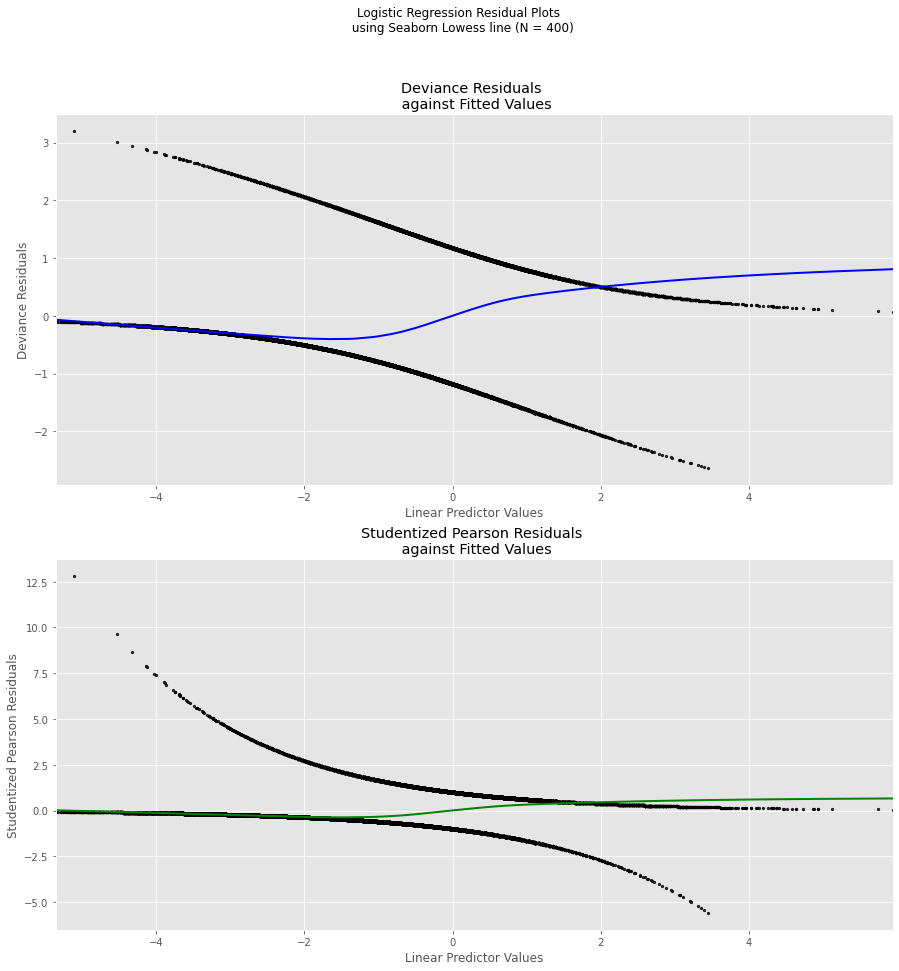

In [49]:
## Plotting multiple plots same figure
fig, (axL, axR) = plt.subplots(2, figsize=(15, 15))
plt.suptitle("Logistic Regression Residual Plots \n using Seaborn Lowess line (N = 400)")


# Deviance Residuals
sns.regplot(model.fittedvalues, model.resid_dev, ax= axL,
            color="black", scatter_kws={"s": 5},
            line_kws={"color":"b", "alpha":1, "lw":2}, lowess=True)

axL.set_title("Deviance Residuals \n against Fitted Values")
axL.set_xlabel("Linear Predictor Values")
axL.set_ylabel("Deviance Residuals")

# Studentized Pearson Residuals
sns.regplot(model.fittedvalues, model.resid_pearson, ax= axR,
            color="black", scatter_kws={"s": 5},
            line_kws={"color":"g", "alpha":1, "lw":2}, lowess=True)

axR.set_title("Studentized Pearson Residuals \n against Fitted Values")
axR.set_xlabel("Linear Predictor Values")
axR.set_ylabel("Studentized Pearson Residuals")

plt.show()

---

## Initial Custody Level Logistic Model from All Data

In [45]:
model_ic_scaled = LogitModelRunner(
    df=df_ic_scaled,
    target_var="custody_level"
)

In [46]:
model_ic_all.init_sklogit_model()
model_ic_all.init_smlogit_model()

In [10]:
model_ic_all.fit()

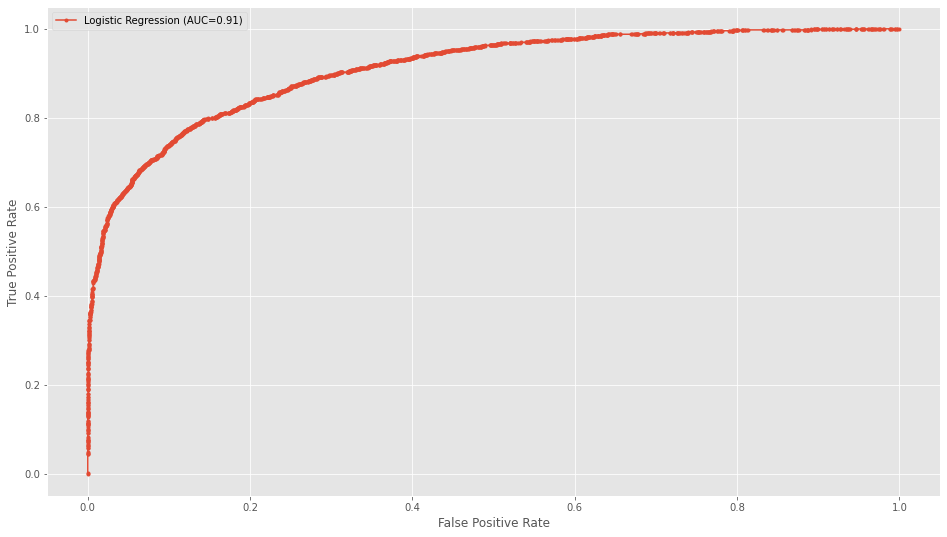

In [11]:
plt.figure(figsize=(16,9))
model_ic_all.plot_sk_roc()
plt.show()

In [12]:
model_ic_all.sm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          custody_level   No. Observations:                23698
Model:                          Logit   Df Residuals:                    23675
Method:                           MLE   Df Model:                           22
Date:                Sat, 18 Sep 2021   Pseudo R-squ.:                  0.4846
Time:                        16:13:16   Log-Likelihood:                -7951.9
converged:                       True   LL-Null:                       -15430.
Covariance Type:            nonrobust   LLR p-value:                     0.000
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -6.6405      0.171    -38.874      0.000      -6.975      -6.306
gender_female       0.2793      0.086      3.247      0.001       0.111       0.448
age_gt_45          -0.7358      0.043    -17.194      0.000      -0.820      -0.652
age_lt_25           0.5289      0.167      3.171      0.002       0.202       0.856
race_B              0.2301      0.047      4.882      0.000       0.138       0.323
race_A              0.5596      0.419      1.335      0.182      -0.262       1.382
race_H             -0.2316      0.069     -3.377      0.001      -0.366      -0.097
race_I              0.2440      0.613      0.398      0.691      -0.958       1.446
race_O              0.1072      0.352      0.305      0.761      -0.582       0.797
off_1_prs_max       0.2825      0.020     13.881      0.000       0.243       0.322
off_1_gs_max        0.1710      0.007     24.052      0.000       0.157       0.185
prior_commits       0.1067      0.007     15.034      0.000       0.093       0.121
ic_institut_adj     1.3915      0.021     67.352      0.000       1.351       1.432
escape_hist_1      -0.7701      0.089     -8.684      0.000      -0.944      -0.596
escape_hist_2      -0.2670      0.078     -3.433      0.001      -0.420      -0.115
escape_hist_3       0.0624      0.079      0.795      0.427      -0.092       0.216
escape_hist_4       1.6506      0.098     16.837      0.000       1.458       1.843
escape_hist_5       2.3711      0.141     16.790      0.000       2.094       2.648
mrt_stat_DIV       -2.3781      0.099    -23.996      0.000      -2.572      -2.184
mrt_stat_SEP       -2.2544      0.126    -17.955      0.000      -2.500      -2.008
mrt_stat_MAR       -2.0404      0.081    -25.301      0.000      -2.198      -1.882
mrt_stat_WID       -1.7784      0.229     -7.765      0.000      -2.227      -1.329
employed           -1.0465      0.053    -19.602      0.000      -1.151      -0.942
===================================================================================
"""

In [13]:
model_ic_all.get_sm_coeffs()

,coef
(Intercept),-6.640493
escape_hist_5,2.371135
escape_hist_4,1.650605
ic_institut_adj,1.391482
race_A,0.559623
age_lt_25,0.528854
off_1_prs_max,0.282514
gender_female,0.279340
race_I,0.244049
race_B,0.230130


### Correlations

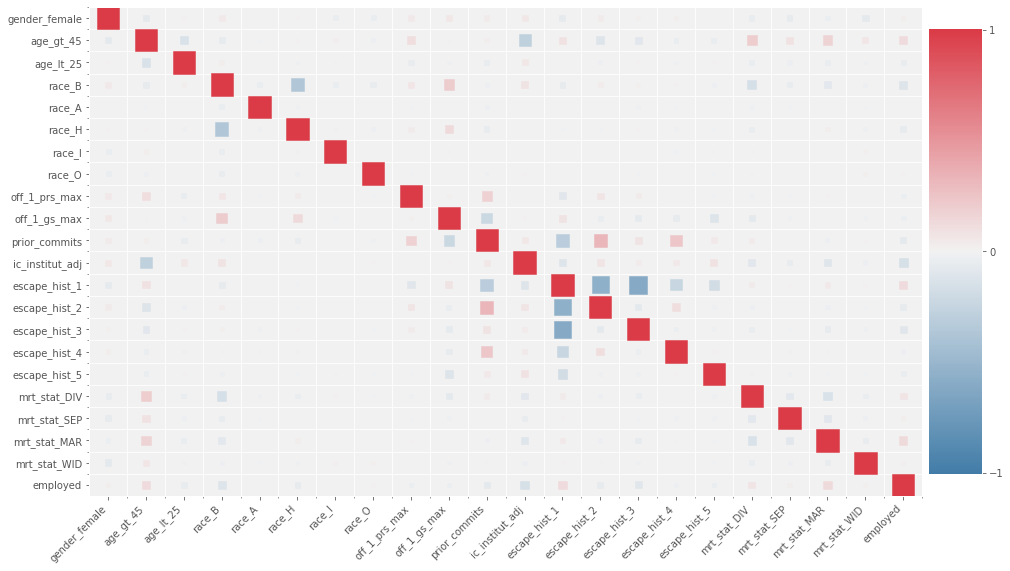

In [14]:
plt.figure(figsize=(16,9))
corrplot(model_ic_all.X_train.corr())
plt.show()

---

## Initial Custody Logistic Model of Inmates in 2017

In [15]:
df_ic_2017_all = preprocess_for_logit(
    pd.read_csv(
        "../data/initial_custody_2017_gsprs.csv",
        low_memory=False
    )
)

df_ic_2017_all = df_ic_2017_all[
    [
        "gender_female",
        "age_gt_45",
        "age_lt_25",
        "race_B",
        "race_A",
        "race_H",
        "race_I",
        "race_O",
        "off_1_prs_max",
        "off_1_gs_max",
        "custody_level",
        "prior_commits",
        "ic_institut_adj",
        "escape_hist_1",
        "escape_hist_2",
        "escape_hist_3",
        "escape_hist_4",
        "escape_hist_5",
        "mrt_stat_DIV",
        "mrt_stat_SEP",
        "mrt_stat_MAR",
        "mrt_stat_WID",
        "employed"
    ]
]

In [16]:
model_ic_2017_all = LogitModelRunner(
    df=df_ic_2017_all,
    target_var="custody_level"
)

In [17]:
model_ic_2017_all.init_sklogit_model()
model_ic_2017_all.init_smlogit_model()

In [18]:
model_ic_2017_all.fit()

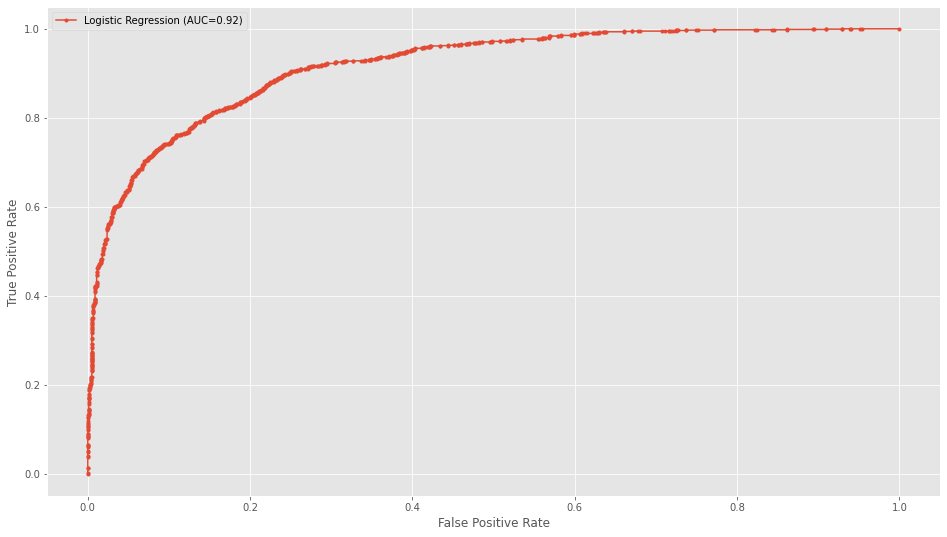

In [19]:
plt.figure(figsize=(16,9))
model_ic_2017_all.plot_sk_roc()
plt.show()

In [20]:
model_ic_2017_all.sm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          custody_level   No. Observations:                 9424
Model:                          Logit   Df Residuals:                     9401
Method:                           MLE   Df Model:                           22
Date:                Sat, 18 Sep 2021   Pseudo R-squ.:                  0.4842
Time:                        16:13:30   Log-Likelihood:                -3339.4
converged:                       True   LL-Null:                       -6474.3
Covariance Type:            nonrobust   LLR p-value:                     0.000
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -8.3198      0.295    -28.236      0.000      -8.897      -7.742
gender_female       0.9330      0.168      5.554      0.000       0.604       1.262
age_gt_45          -0.2470      0.070     -3.541      0.000      -0.384      -0.110
age_lt_25           0.1731      0.245      0.707      0.480      -0.307       0.653
race_B              0.4692      0.069      6.807      0.000       0.334       0.604
race_A              1.0464      0.579      1.807      0.071      -0.088       2.181
race_H              0.0716      0.105      0.682      0.495      -0.134       0.277
race_I              1.8073      1.333      1.356      0.175      -0.806       4.420
race_O              0.8629      0.501      1.722      0.085      -0.119       1.845
off_1_prs_max       0.3807      0.029     12.998      0.000       0.323       0.438
off_1_gs_max        0.2897      0.012     24.320      0.000       0.266       0.313
prior_commits       0.0436      0.010      4.270      0.000       0.024       0.064
ic_institut_adj     1.3457      0.032     42.164      0.000       1.283       1.408
escape_hist_1      -0.6840      0.133     -5.145      0.000      -0.945      -0.423
escape_hist_2      -0.3516      0.116     -3.025      0.002      -0.579      -0.124
escape_hist_3       0.3212      0.110      2.912      0.004       0.105       0.537
escape_hist_4       1.6626      0.144     11.511      0.000       1.380       1.946
escape_hist_5       2.6936      0.289      9.310      0.000       2.127       3.261
mrt_stat_DIV       -2.3350      0.139    -16.771      0.000      -2.608      -2.062
mrt_stat_SEP       -2.2573      0.163    -13.813      0.000      -2.578      -1.937
mrt_stat_MAR       -1.8046      0.115    -15.740      0.000      -2.029      -1.580
mrt_stat_WID       -1.8623      0.275     -6.769      0.000      -2.402      -1.323
employed           -1.0560      0.078    -13.490      0.000      -1.209      -0.903
===================================================================================
"""

In [21]:
model_ic_2017_all.get_sm_coeffs()

,coef
(Intercept),-8.319763
escape_hist_5,2.693628
race_I,1.807316
escape_hist_4,1.662635
ic_institut_adj,1.345673
race_A,1.046350
gender_female,0.932999
race_O,0.862900
race_B,0.469169
off_1_prs_max,0.380665


### Correlations

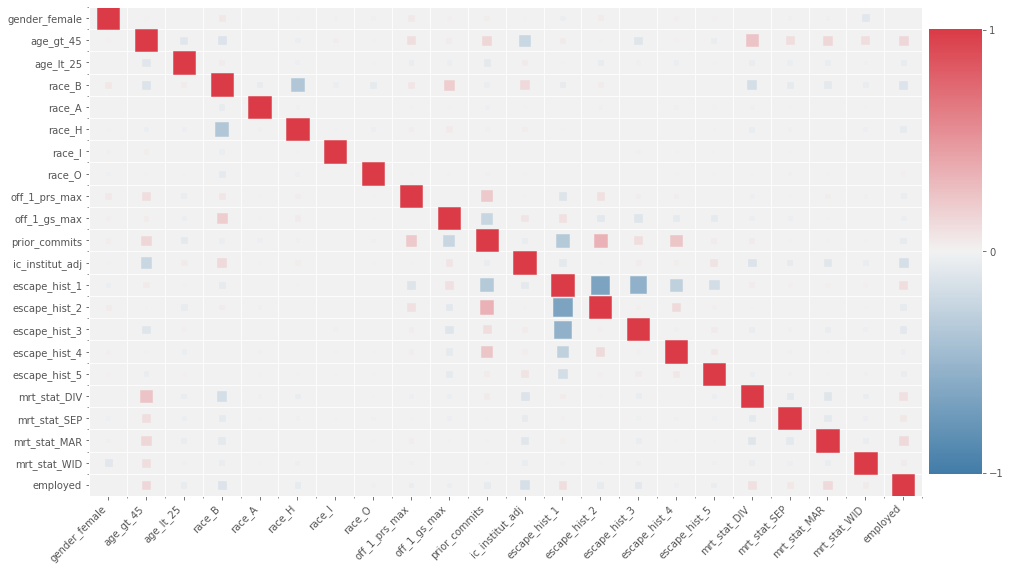

In [22]:
plt.figure(figsize=(16,9))
corrplot(model_ic_2017_all.X_train.corr())
plt.show()